This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


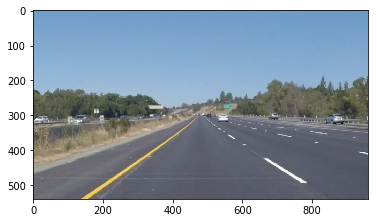

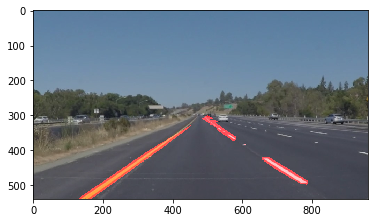

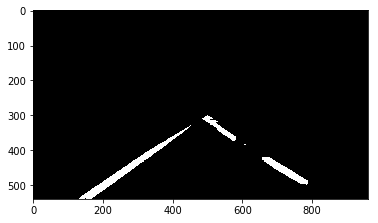

0.623781283566 -0.661578654134
505 216
530 139
534 134
344 528
419 676
445 680
538 168
303 494
384 358
309 484
426 688
463 708
396 338
429 658
353 410
427 325
428 657


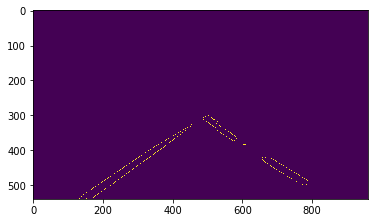

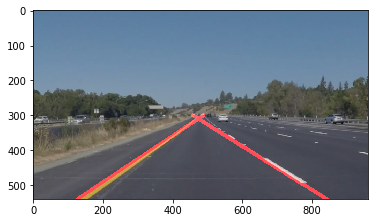

In [14]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


#reading in an image
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidYellowLeft.jpg')
color_select= np.copy(image)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180*1
threshold = 15
min_line_length = 40
max_line_gap = 20
line_image = np.copy(image)*0 #creating a blank to draw lines on
color_image = np.copy(image)*0 #creating a blank to draw lines on
# Run Hough on edge detected image
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Define a triangle region of interest 
left_bottom = [80, 550]
right_bottom = [900, 550]
apex = [500, 300]

fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

ysize = image.shape[0]
xsize = image.shape[1]
# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

# Define our color criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]
# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

line_image[~region_thresholds] = [0,0,0]
color_image[~color_thresholds & region_thresholds] = [255,0,0]
final_mask = cv2.add(line_image,color_image)
combo2 = cv2.addWeighted(color_select, 0.8, final_mask, 1, 0)
plt.show()
plt.imshow(combo2)

merge_mask = np.zeros_like(color_select)
merge_mask[final_mask[:,:,0] == 255] = 255
plt.show()
plt.imshow(merge_mask)
# Define our parameters for Canny and apply
low_threshold = 0
high_threshold = 255
edges = cv2.Canny(merge_mask, low_threshold, high_threshold)
plt.show()
plt.imshow(edges)

rho = 1
theta = np.pi/180*1
threshold = 15
min_line_length = 40
max_line_gap = 20
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
slope_left = 0
slope_right = 0
num_left = 0
num_right = 0

for line in lines:
    for x1,y1,x2,y2 in line:
        #left side line
        if x1 < apex[0] and x2 < apex[0]:
            temp = (y2 - y1) / (x2 - x1 + 0.000001)
            slope_left = slope_left + temp
            num_left = num_left + 1
        #right side line
        if x1 > apex[0] and x2 > apex[0]:
            temp = (y2 - y1) / (x2 - x1 + 0.000001)
            slope_right = slope_right + temp
            num_right = num_right + 1 
slope_right = slope_right / num_right
slope_left = slope_left / num_left

print(slope_right,slope_left)
#find start point
start_x_left = 0
start_x_right = 0
start_y_left = ysize
start_y_right = ysize

for line in lines:
    for x1,y1,x2,y2 in line:
        print(y1,x1)
        if x1 < apex[0] and x2 < apex[0]:
            if start_y_left > y1:
                start_y_left = y1
                start_x_left = x1
        if x1 > apex[0] and x2 > apex[0]:
            if start_y_right > y1:
                start_y_right = y1
                start_x_right = x1
end_y = ysize
end_x_left = int((end_y - start_y_left) / slope_left + start_x_left)
end_x_right = int((end_y - start_y_right) / slope_right + start_x_right)

end_x_left = max(0,end_x_left)
end_x_left = min(xsize,end_x_left)
end_x_right = max(0,end_x_right)
end_x_right = min(xsize,end_x_right)

#unify the y coordinate
start_y = 300
start_x_left = int(end_x_left - (end_y - start_y) / slope_left)
start_x_right = int(end_x_right - (end_y - start_y) / slope_right)

color_image2 = np.copy(image)*0 

cv2.line(color_image2,(start_x_left,start_y),(end_x_left,end_y),(255,0,0),10)
cv2.line(color_image2,(start_x_right,start_y),(end_x_right,end_y),(255,0,0),10)
combo3 = cv2.addWeighted(image, 0.8, color_image2, 1, 0)
plt.show()
plt.imshow(combo3)